In [1]:
#!python main.py --phase=test --model_file='./models/289999.npy' --beam_size=3

In [2]:
%matplotlib inline
import tensorflow as tf

In [3]:
from config import Config

In [4]:
config = Config()
config.phase = 'test'
model_file = './models/289999.npy'
config.beam_size = 3

In [5]:
from dataset import prepare_test_data
data, vocabulary = prepare_test_data(config)

Building the vocabulary...
Vocabulary built.
Number of words = 5000
Building the dataset...
Dataset built.


In [6]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cPickle as pickle
import copy
import json
from tqdm import tqdm

from utils.nn import NN
from utils.coco.coco import COCO
from utils.coco.pycocoevalcap.eval import COCOEvalCap
from utils.misc import ImageLoader, CaptionData, TopN

from types import MethodType

In [7]:
class BaseModel(object):
    def __init__(self, config):
        self.config = config
        self.is_train = True if config.phase == 'train' else False
        self.train_cnn = self.is_train and config.train_cnn
        self.image_loader = ImageLoader('./utils/ilsvrc_2012_mean.npy')
        self.image_shape = [224, 224, 3]
        self.nn = NN(config)
        self.global_step = tf.Variable(0,
                                       name = 'global_step',
                                       trainable = False)
        self.build()
        
    def build(self):
        raise NotImplementedError()

In [8]:
#mymodel = BaseModel(config)

In [9]:
class CaptionGenerator(BaseModel):

    def build(self):

        """ Build the model. """
        self.build_vgg16()
        self.build_rnn()
        

In [10]:
def build_vgg16(self):

        """ Build the VGG16 net. """
        print("Building VGG16...")

        config = self.config

        images = tf.placeholder(
            dtype = tf.float32,
            shape = [config.batch_size] + self.image_shape)

        conv1_1_feats = self.nn.conv2d(images, 64, name = 'conv1_1')
        conv1_2_feats = self.nn.conv2d(conv1_1_feats, 64, name = 'conv1_2')
        pool1_feats = self.nn.max_pool2d(conv1_2_feats, name = 'pool1')

        conv2_1_feats = self.nn.conv2d(pool1_feats, 128, name = 'conv2_1')
        conv2_2_feats = self.nn.conv2d(conv2_1_feats, 128, name = 'conv2_2')
        pool2_feats = self.nn.max_pool2d(conv2_2_feats, name = 'pool2')

        conv3_1_feats = self.nn.conv2d(pool2_feats, 256, name = 'conv3_1')
        conv3_2_feats = self.nn.conv2d(conv3_1_feats, 256, name = 'conv3_2')
        conv3_3_feats = self.nn.conv2d(conv3_2_feats, 256, name = 'conv3_3')
        pool3_feats = self.nn.max_pool2d(conv3_3_feats, name = 'pool3')

        conv4_1_feats = self.nn.conv2d(pool3_feats, 512, name = 'conv4_1')
        conv4_2_feats = self.nn.conv2d(conv4_1_feats, 512, name = 'conv4_2')
        conv4_3_feats = self.nn.conv2d(conv4_2_feats, 512, name = 'conv4_3')
        pool4_feats = self.nn.max_pool2d(conv4_3_feats, name = 'pool4')

        conv5_1_feats = self.nn.conv2d(pool4_feats, 512, name = 'conv5_1')
        conv5_2_feats = self.nn.conv2d(conv5_1_feats, 512, name = 'conv5_2')
        conv5_3_feats = self.nn.conv2d(conv5_2_feats, 512, name = 'conv5_3')

        reshaped_conv5_3_feats = tf.reshape(conv5_3_feats,
                                            [config.batch_size, 196, 512])

        self.conv_feats = reshaped_conv5_3_feats
        self.num_ctx = 196
        self.dim_ctx = 512
        self.images = images
        print("CNN built.")

In [11]:
# this assigns the method to the class definition
CaptionGenerator.build_vgg16 = MethodType(build_vgg16, None, CaptionGenerator)

In [12]:
def build_rnn(self):

        """ Build the RNN. """
        print("Building the RNN...")

        config = self.config

        # Setup the placeholders

        if self.is_train:
            pass
        else:

            contexts = tf.placeholder(
                dtype = tf.float32,
                shape = [config.batch_size, self.num_ctx, self.dim_ctx])

            last_memory = tf.placeholder(
                dtype = tf.float32,
                shape = [config.batch_size, config.num_lstm_units])

            last_output = tf.placeholder(
                dtype = tf.float32,
                shape = [config.batch_size, config.num_lstm_units])

            last_word = tf.placeholder(
                dtype = tf.int32,
                shape = [config.batch_size])

        # Setup the word embedding

        with tf.variable_scope("word_embedding"):

            embedding_matrix = tf.get_variable(
                name = 'weights',
                shape = [config.vocabulary_size, config.dim_embedding],
                initializer = self.nn.fc_kernel_initializer,
                regularizer = self.nn.fc_kernel_regularizer,
                trainable = self.is_train)

        # Setup the LSTM

        lstm = tf.nn.rnn_cell.LSTMCell(
            config.num_lstm_units,
            initializer = self.nn.fc_kernel_initializer)

        if self.is_train:
            pass

        # Initialize the LSTM using the mean context

        with tf.variable_scope("initialize"):
            context_mean = tf.reduce_mean(self.conv_feats, axis = 1)
            initial_memory, initial_output = self.initialize(context_mean)
            initial_state = initial_memory, initial_output

        # Prepare to run

        predictions = []
        if self.is_train:
            pass

        else:
            num_steps = 1
        last_state = last_memory, last_output

        # Generate the words one by one
        for idx in range(num_steps):

            # Attention mechanism
            with tf.variable_scope("attend"):
                alpha = self.attend(contexts, last_output)
                context = tf.reduce_sum(contexts*tf.expand_dims(alpha, 2),
                                        axis = 1)

                if self.is_train:
                    pass

            # Embed the last word
            with tf.variable_scope("word_embedding"):
                word_embed = tf.nn.embedding_lookup(embedding_matrix,
                                                    last_word)

           # Apply the LSTM

            with tf.variable_scope("lstm"):
                current_input = tf.concat([context, word_embed], 1)
                output, state = lstm(current_input, last_state)
                memory, _ = state

            # Decode the expanded output of LSTM into a word

            with tf.variable_scope("decode"):
                expanded_output = tf.concat([output,
                                             context,
                                             word_embed],
                                             axis = 1)

                logits = self.decode(expanded_output)
                probs = tf.nn.softmax(logits)
                prediction = tf.argmax(logits, 1)
                predictions.append(prediction)


            # Compute the loss for this step, if necessary

            if self.is_train:
                pass
            
            tf.get_variable_scope().reuse_variables()


        # Compute the final loss, if necessary
        if self.is_train:
            pass

        self.contexts = contexts
        if self.is_train:
            pass

        else:
            self.initial_memory = initial_memory
            self.initial_output = initial_output
            self.last_memory = last_memory
            self.last_output = last_output
            self.last_word = last_word
            self.memory = memory
            self.output = output
            self.probs = probs

        print("RNN built.")

In [13]:
CaptionGenerator.build_rnn = MethodType(build_rnn, None, CaptionGenerator)

In [14]:
def initialize(self, context_mean):

        """ Initialize the LSTM using the mean context. """

        config = self.config
        context_mean = self.nn.dropout(context_mean)

        if config.num_initalize_layers == 1:

            # use 1 fc layer to initialize
            memory = self.nn.dense(context_mean,
                                   units = config.num_lstm_units,
                                   activation = None,
                                   name = 'fc_a')

            output = self.nn.dense(context_mean,
                                   units = config.num_lstm_units,
                                   activation = None,
                                   name = 'fc_b')

        else:
            # use 2 fc layers to initialize
            temp1 = self.nn.dense(context_mean,
                                  units = config.dim_initalize_layer,
                                  activation = tf.tanh,
                                  name = 'fc_a1')

            temp1 = self.nn.dropout(temp1)
            memory = self.nn.dense(temp1,
                                   units = config.num_lstm_units,
                                   activation = None,
                                   name = 'fc_a2')


            temp2 = self.nn.dense(context_mean,
                                  units = config.dim_initalize_layer,
                                  activation = tf.tanh,
                                  name = 'fc_b1')

            temp2 = self.nn.dropout(temp2)

            output = self.nn.dense(temp2,
                                   units = config.num_lstm_units,
                                   activation = None,
                                   name = 'fc_b2')

        return memory, output



In [15]:
CaptionGenerator.initialize= MethodType(initialize, None, CaptionGenerator)

In [16]:
def attend(self, contexts, output):

        """ Attention Mechanism. """
        config = self.config
        reshaped_contexts = tf.reshape(contexts, [-1, self.dim_ctx])
        reshaped_contexts = self.nn.dropout(reshaped_contexts)
        output = self.nn.dropout(output)

        if config.num_attend_layers == 1:
            # use 1 fc layer to attend
            logits1 = self.nn.dense(reshaped_contexts,
                                    units = 1,
                                    activation = None,
                                    use_bias = False,
                                    name = 'fc_a')

            logits1 = tf.reshape(logits1, [-1, self.num_ctx])
            logits2 = self.nn.dense(output,
                                    units = self.num_ctx,
                                    activation = None,
                                    use_bias = False,
                                    name = 'fc_b')

            logits = logits1 + logits2
        else:

            # use 2 fc layers to attend
            temp1 = self.nn.dense(reshaped_contexts,
                                  units = config.dim_attend_layer,
                                  activation = tf.tanh,
                                  name = 'fc_1a')

            temp2 = self.nn.dense(output,
                                  units = config.dim_attend_layer,
                                  activation = tf.tanh,
                                  name = 'fc_1b')

            temp2 = tf.tile(tf.expand_dims(temp2, 1), [1, self.num_ctx, 1])
            temp2 = tf.reshape(temp2, [-1, config.dim_attend_layer])
            temp = temp1 + temp2
            temp = self.nn.dropout(temp)

            logits = self.nn.dense(temp,
                                   units = 1,
                                   activation = None,
                                   use_bias = False,
                                   name = 'fc_2')

            logits = tf.reshape(logits, [-1, self.num_ctx])

        alpha = tf.nn.softmax(logits)

        return alpha

In [17]:
CaptionGenerator.attend= MethodType(attend, None, CaptionGenerator)

In [18]:
def decode(self, expanded_output):

        """ Decode the expanded output of the LSTM into a word. """
        config = self.config
        expanded_output = self.nn.dropout(expanded_output)

        if config.num_decode_layers == 1:
            # use 1 fc layer to decode

            logits = self.nn.dense(expanded_output,
                                   units = config.vocabulary_size,
                                   activation = None,
                                   name = 'fc')

        else:

            # use 2 fc layers to decode
            temp = self.nn.dense(expanded_output,
                                 units = config.dim_decode_layer,
                                 activation = tf.tanh,
                                 name = 'fc_1')

            temp = self.nn.dropout(temp)

            logits = self.nn.dense(temp,
                                   units = config.vocabulary_size,
                                   activation = None,
                                   name = 'fc_2')

        return logits

In [19]:
CaptionGenerator.decode = MethodType(decode, None, CaptionGenerator)

In [20]:
mymodel = CaptionGenerator(config)

Building VGG16...
CNN built.
Building the RNN...
RNN built.


In [21]:
def load(self, sess, model_file=None):
        """ Load the model. """
        config = self.config
        if model_file is not None:
            save_path = model_file
        else:
            info_path = os.path.join(config.save_dir, "config.pickle")
            info_file = open(info_path, "rb")
            config = pickle.load(info_file)
            global_step = config.global_step
            info_file.close()
            save_path = os.path.join(config.save_dir,
                                     str(global_step)+".npy")

        print("Loading the model from %s..." %save_path)
        data_dict = np.load(save_path).item()
        count = 0
        for v in tqdm(tf.global_variables()):
            if v.name in data_dict.keys():
                sess.run(v.assign(data_dict[v.name]))
                count += 1
        print("%d tensors loaded." %count)

In [22]:
#from types import MethodType
# this assigns the method to the class definition
BaseModel.load = MethodType(load, None, BaseModel)

In [23]:
#with tf.Session() as sess:
#    mymodel.load(sess, model_file)

In [24]:
def test(self, sess, test_data, vocabulary):
        """ Test the model using any given images. """
        print("Testing the model ...")
        config = self.config

        if not os.path.exists(config.test_result_dir):
            os.mkdir(config.test_result_dir)

        captions = []
        scores = []

        # Generate the captions for the images
        for k in tqdm(list(range(test_data.num_batches)), desc='path'):
            batch = test_data.next_batch()
            caption_data = self.beam_search(sess, batch, vocabulary)

            fake_cnt = 0 if k<test_data.num_batches-1 \
                         else test_data.fake_count
            for l in range(test_data.batch_size-fake_cnt):
                word_idxs = caption_data[l][0].sentence
                score = caption_data[l][0].score
                caption = vocabulary.get_sentence(word_idxs)
                captions.append(caption)
                scores.append(score)

                # Save the result in an image file
                image_file = batch[l]
                image_name = image_file.split(os.sep)[-1]
                image_name = os.path.splitext(image_name)[0]
                img = mpimg.imread(image_file)
                plt.figure(figsize = (5,5))
                plt.imshow(img)
                plt.axis('off')
                plt.title(caption)
                plt.show()
                plt.savefig(os.path.join(config.test_result_dir,
                                         image_name+'_result.jpg'))

        # Save the captions to a file
        results = pd.DataFrame({'image_files':test_data.image_files,
                                'caption':captions,
                                'prob':scores})
        results.to_csv(config.test_result_file)
        print("Testing complete.")

In [25]:
#from types import MethodType
# this assigns the method to the class definition
BaseModel.test = MethodType(test, None, BaseModel)

In [26]:
def beam_search(self, sess, image_files, vocabulary):
        """Use beam search to generate the captions for a batch of images."""
        # Feed in the images to get the contexts and the initial LSTM states
        config = self.config
        images = self.image_loader.load_images(image_files)
        contexts, initial_memory, initial_output = sess.run(
            [self.conv_feats, self.initial_memory, self.initial_output],
            feed_dict = {self.images: images})

        partial_caption_data = []
        complete_caption_data = []
        for k in range(config.batch_size):
            initial_beam = CaptionData(sentence = [],
                                       memory = initial_memory[k],
                                       output = initial_output[k],
                                       score = 1.0)
            partial_caption_data.append(TopN(config.beam_size))
            partial_caption_data[-1].push(initial_beam)
            complete_caption_data.append(TopN(config.beam_size))

        # Run beam search
        for idx in range(config.max_caption_length):
            partial_caption_data_lists = []
            for k in range(config.batch_size):
                data = partial_caption_data[k].extract()
                partial_caption_data_lists.append(data)
                partial_caption_data[k].reset()

            num_steps = 1 if idx == 0 else config.beam_size
            for b in range(num_steps):
                if idx == 0:
                    last_word = np.zeros((config.batch_size), np.int32)
                else:
                    last_word = np.array([pcl[b].sentence[-1]
                                        for pcl in partial_caption_data_lists],
                                        np.int32)

                last_memory = np.array([pcl[b].memory
                                        for pcl in partial_caption_data_lists],
                                        np.float32)
                last_output = np.array([pcl[b].output
                                        for pcl in partial_caption_data_lists],
                                        np.float32)

                memory, output, scores = sess.run(
                    [self.memory, self.output, self.probs],
                    feed_dict = {self.contexts: contexts,
                                 self.last_word: last_word,
                                 self.last_memory: last_memory,
                                 self.last_output: last_output})

                # Find the beam_size most probable next words
                for k in range(config.batch_size):
                    caption_data = partial_caption_data_lists[k][b]
                    words_and_scores = list(enumerate(scores[k]))
                    words_and_scores.sort(key=lambda x: -x[1])
                    words_and_scores = words_and_scores[0:config.beam_size+1]

                    # Append each of these words to the current partial caption
                    for w, s in words_and_scores:
                        sentence = caption_data.sentence + [w]
                        score = caption_data.score * s
                        beam = CaptionData(sentence,
                                           memory[k],
                                           output[k],
                                           score)
                        if vocabulary.words[w] == '.':
                            complete_caption_data[k].push(beam)
                        else:
                            partial_caption_data[k].push(beam)

        results = []
        for k in range(config.batch_size):
            if complete_caption_data[k].size() == 0:
                complete_caption_data[k] = partial_caption_data[k]
            results.append(complete_caption_data[k].extract(sort=True))

        return results
BaseModel.beam_search = MethodType(beam_search, None, BaseModel)

  0%|          | 0/47 [00:00<?, ?it/s]

Loading the model from ./models/289999.npy...


path:   0%|          | 0/1 [00:00<?, ?it/s]

47 tensors loaded.
Testing the model ...


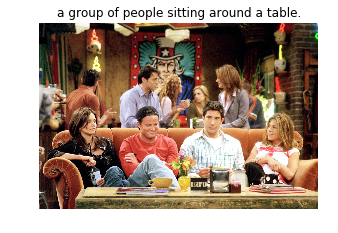

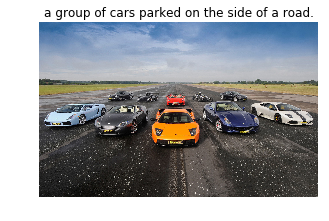

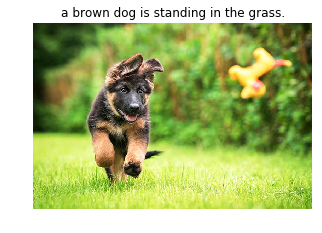

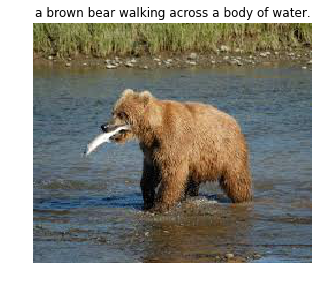

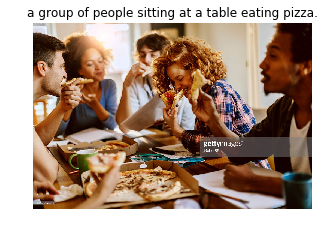

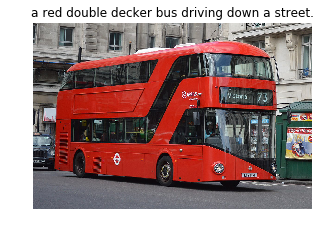

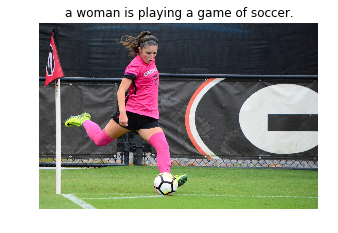

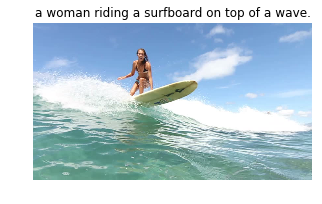

path: 100%|██████████| 1/1 [00:14<00:00, 14.86s/it]

Testing complete.


In [27]:
 with tf.Session() as sess:
    mymodel.load(sess, model_file)
    tf.get_default_graph().finalize()
    mymodel.test(sess, data, vocabulary)